In [9]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import os

for dirname, _, filenames in os.walk("."):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./.DS_Store
./ds202_analysis.ipynb
./glove.840B.300d.pkl
./analysis2.ipynb
./jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv
./jigsaw-unintended-bias-in-toxicity-classification/identity_individual_annotations.csv
./jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv
./jigsaw-unintended-bias-in-toxicity-classification/test.csv
./jigsaw-unintended-bias-in-toxicity-classification/all_data.csv
./jigsaw-unintended-bias-in-toxicity-classification/toxicity_individual_annotations.csv
./jigsaw-unintended-bias-in-toxicity-classification/train.csv
./jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv


In [10]:
train = pd.read_csv(
    "jigsaw-unintended-bias-in-toxicity-classification/train.csv"
)
test = pd.read_csv(
    "jigsaw-unintended-bias-in-toxicity-classification/test.csv"
)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [12]:
train_sample = train.sample(frac=0.1, random_state=42, axis="index")

In [13]:
from bs4 import BeautifulSoup  # Text Cleaning
import re, string  # Regular Expressions, String
from nltk.corpus import stopwords  # stopwords
from nltk.stem.porter import PorterStemmer  # for word stemming
from nltk.stem import WordNetLemmatizer  # for word lemmatization
import unicodedata
import html

# set of stopwords to be removed from text
stop = set(stopwords.words("english"))

# update stopwords to have punctuation too
stop.update(list(string.punctuation))


def clean_text(text):

    # Remove unwanted html characters
    re1 = re.compile(r"  +")
    x1 = (
        text.lower()
        .replace("#39;", "'")
        .replace("amp;", "&")
        .replace("#146;", "'")
        .replace("nbsp;", " ")
        .replace("#36;", "$")
        .replace("\\n", "\n")
        .replace("quot;", "'")
        .replace("<br />", "\n")
        .replace('\\"', '"')
        .replace("<unk>", "u_n")
        .replace(" @.@ ", ".")
        .replace(" @-@ ", "-")
        .replace("\\", " \\ ")
    )
    text = re1.sub(" ", html.unescape(x1))

    # remove non-ascii characters
    text = (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )

    #     # strip html
    #     soup = BeautifulSoup(text, 'html.parser')
    #     text = soup.get_text()

    # remove between square brackets
    text = re.sub("\[[^]]*\]", "", text)

    # remove URLs
    text = re.sub(r"http\S+", "", text)

    # remove twitter tags
    text = text.replace("@", "")

    # remove hashtags
    text = text.replace("#", "")

    # remove all non-alphabetic characters
    text = re.sub(r"[^a-zA-Z ]", "", text)

    # remove stopwords from text
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip().lower())

    text = " ".join(final_text)

    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([lemmatizer.lemmatize(word, pos="v") for word in text.split()])

    # replace all numbers with "num"
    text = re.sub("\d", "num", text)

    return text.lower()

<>:50: SyntaxWarning: invalid escape sequence '\['
<>:78: SyntaxWarning: invalid escape sequence '\d'
<>:50: SyntaxWarning: invalid escape sequence '\['
<>:78: SyntaxWarning: invalid escape sequence '\d'
/var/folders/7g/f8wv1hz96056pmbvhy90v0n80000gn/T/ipykernel_33787/2321238962.py:50: SyntaxWarning: invalid escape sequence '\['
  text = re.sub("\[[^]]*\]", "", text)
/var/folders/7g/f8wv1hz96056pmbvhy90v0n80000gn/T/ipykernel_33787/2321238962.py:78: SyntaxWarning: invalid escape sequence '\d'
  text = re.sub("\d", "num", text)


In [14]:
train_data = train
train_data["threat"] = np.where(train_data["threat"] >= 0.25, 1, 0)
train_data["severe_toxicity"] = np.where(train_data["severe_toxicity"] >= 0.25, 1, 0)
train_data["insult"] = np.where(train_data["insult"] >= 0.25, 1, 0)
train_data["obscene"] = np.where(train_data["obscene"] >= 0.25, 1, 0)
train_data["identity_attack"] = np.where(train_data["identity_attack"] >= 0.25, 1, 0)

In [15]:
possible_labels = [
    "comment_text",
    "target",
    "severe_toxicity",
    "obscene",
    "threat",
    "insult",
    "identity_attack",
]

In [16]:
train_data_final = train_data[possible_labels]
train_data_final = train_data_final[(train_data_final["target"] >= 0.5)]
train_data_final.head()

,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0
5,ur a sh*tty comment.,0.666667,0,1,0,1,0
13,It's ridiculous that these guys are being call...,0.600000,0,0,0,1,0
14,This story gets more ridiculous by the hour! A...,0.500000,0,0,0,1,0
19,"Angry trolls, misogynists and Racists"", oh my....",0.500000,0,0,0,1,0


In [17]:
possible_labels1 = ["severe_toxicity", "obscene", "threat", "insult", "identity_attack"]
targets = train_data_final[possible_labels].values

In [18]:
len(train_data_final)

144334

In [19]:
train_data_final["clean_comment_text"] = train_data_final["comment_text"].apply(
    clean_text
)

In [20]:
train_data_final.head(5)

,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack,clean_comment_text
4,haha you guys are a bunch of losers.,0.893617,0,0,0,1,0,haha guy bunch loser
5,ur a sh*tty comment.,0.666667,0,1,0,1,0,ur shtty comment
13,It's ridiculous that these guys are being call...,0.600000,0,0,0,1,0,ridiculous guy call protester arm threat viole...
14,This story gets more ridiculous by the hour! A...,0.500000,0,0,0,1,0,story get ridiculous hour love people send guy...
19,"Angry trolls, misogynists and Racists"", oh my....",0.500000,0,0,0,1,0,angry troll misogynist racist oh doesnt take i...


(array([1.03073e+05, 2.78780e+04, 1.18550e+04, 1.52700e+03, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0. ,  30.4,  60.8,  91.2, 121.6, 152. , 182.4, 212.8, 243.2,
        273.6, 304. ]),
 <BarContainer object of 10 artists>)

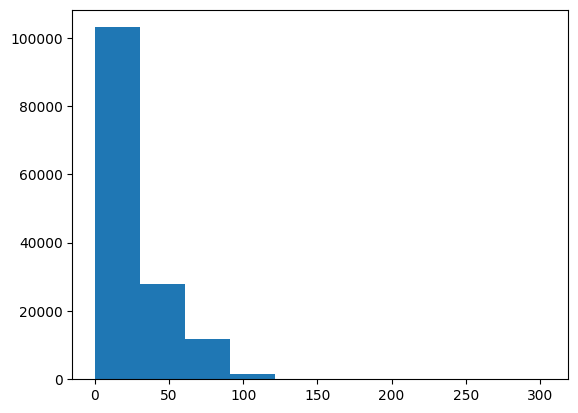

In [21]:
import matplotlib.pyplot as plt

plt.hist(list(train_data_final["clean_comment_text"].str.split().map(lambda x: len(x))))

In [56]:
np.median(
    np.array(train_data_final["clean_comment_text"].str.split().map(lambda x: len(x)))
)

18.0

In [57]:
embedding_dict = pd.read_pickle(
    "tokenizer.pkl"
)

In [58]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Setting up the tokenizer
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="UNK")
tokenizer.fit_on_texts(list(train_data_final["clean_comment_text"]))

max_len = 18
X_train_seq = tokenizer.texts_to_sequences(train_data_final["clean_comment_text"])

X_train_seq = pad_sequences(
    X_train_seq, maxlen=max_len, truncating="post", padding="post"
)
# X_test_seq = pad_sequences(X_test_seq, maxlen = max_len, truncating = 'post', padding = 'post')


print(f"X_train shape: {X_train_seq.shape}")

X_train shape: (144334, 18)


In [59]:
y_train = np.array(train_data_final[possible_labels1]).astype(int)
print(f"y_train shape: {y_train.shape}")

y_train shape: (144334, 5)


In [60]:
from sklearn.model_selection import train_test_split

X_train_seq, X_val_seq, y_train, y_val = train_test_split(
    X_train_seq, y_train, test_size=0.2, random_state=42
)

print(f"X_train shape: {X_train_seq.shape}")
print(f"X_val shape: {X_val_seq.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (115467, 18)
X_val shape: (28867, 18)
y_train shape: (115467, 5)
y_val shape: (28867, 5)


In [61]:
num_words = len(tokenizer.word_index)
print(f"Number of unique words: {num_words}")

Number of unique words: 135845


In [62]:
embedding_matrix = np.zeros((num_words, 300))

for word, i in tokenizer.word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

embedding_matrix.shape

(135845, 300)

In [63]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


def setup_lstm_model(max_len, n_latent_factors):

    model = Sequential()
    model.add(
        layers.Embedding(
            num_words,
            n_latent_factors,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False,
        )
    )
    model.add(layers.LSTM(units=max_len, return_sequences=True))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(units=5, activation="sigmoid"))

    return model

In [64]:
lstm_model = setup_lstm_model(max_len=max_len, n_latent_factors=300)
lstm_model.summary()

/Users/gokulganesan/.pyenv/versions/3.12.2/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    40,753,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,753,500 (155.46 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 40,753,500 (155.46 MB)

In [65]:
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

batch_size = 128
epochs = 10

lstm_model.fit(
    X_train_seq,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_seq, y_val),
)

Epoch 1/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7379 - loss: 0.3089 - val_accuracy: 0.7572 - val_loss: 0.1988
Epoch 2/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7595 - loss: 0.1922 - val_accuracy: 0.7676 - val_loss: 0.1825
Epoch 3/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7674 - loss: 0.1802 - val_accuracy: 0.7732 - val_loss: 0.1767
Epoch 4/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7711 - loss: 0.1724 - val_accuracy: 0.7755 - val_loss: 0.1735
Epoch 5/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7736 - loss: 0.1684 - val_accuracy: 0.7793 - val_loss: 0.1718
Epoch 6/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7772 - loss: 0.1651 - val_accuracy: 0.7773 - val_loss: 0.1704
Epoch 7/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7781 - loss: 0.1636 - val_accuracy: 0.7764 - val_loss: 0.1699
Epoch 8/10
903/903 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7801 - loss: 0.1616 - val_accuracy: 0.

In [66]:
lstm_model.history.history
lstm_model.save("lstm_model.h5")

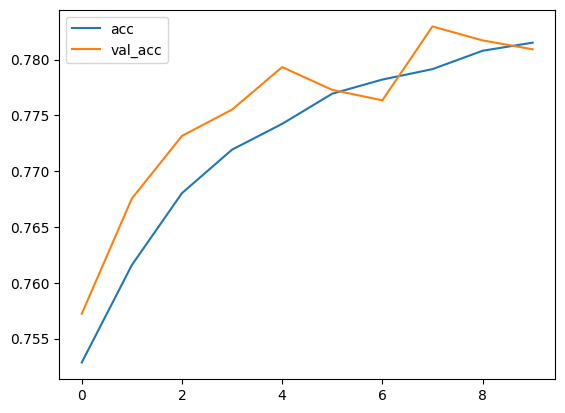

Training Accuracy is  : 0.7815219759941101
Validation Accuracy is: 0.7829701900482178


In [67]:
plt.plot(lstm_model.history.history["accuracy"], label="acc")
plt.plot(lstm_model.history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.show()

print("Training Accuracy is  :", max(lstm_model.history.history["accuracy"]))
print("Validation Accuracy is:", max(lstm_model.history.history["val_accuracy"]))


# Analysis

In [76]:
import numpy as np

# Example comments with identity terms
identity_comments = [
    "I think gay people are great.",
    "Black people are so talented.",
    "Lesbian rights are important.",
    "White people need to be respected.",
    "I love this!",
    "I hate this!",
]

# Labels representing if a comment is toxic (1) or non-toxic (0)
# Adjust these labels based on your dataset
identity_comments_labels = [0.5, 0, 0, 0, 0, 1]

# Tokenize and pad identity comments
identity_comments_sequences = tokenizer.texts_to_sequences(identity_comments)
identity_comments_padded = pad_sequences(identity_comments_sequences, maxlen=max_len)

# Get model predictions
identity_comments_predictions = lstm_model.predict(identity_comments_padded)
identity_comments_predictions = (
    (identity_comments_predictions > 0.5).astype(int).flatten()
)

# Calculate accuracy per subgroup
accuracy_per_subgroup = {}
subgroups = ["LGBTQ+", "Black", "Lesbian", "White", "Neutral", "Negative"]
for subgroup, true_label, predicted_label in zip(
    subgroups, identity_comments_labels, identity_comments_predictions
):
    accuracy_per_subgroup[subgroup] = {"True": true_label, "Predicted": predicted_label}

print("Subgroup Analysis Results:")
print(accuracy_per_subgroup)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Subgroup Analysis Results:
{'LGBTQ+': {'True': 0.5, 'Predicted': 0}, 'Black': {'True': 0, 'Predicted': 0}, 'Lesbian': {'True': 0, 'Predicted': 0}, 'White': {'True': 0, 'Predicted': 1}, 'Neutral': {'True': 0, 'Predicted': 0}, 'Negative': {'True': 1, 'Predicted': 0}}


In [79]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
identity_comments_sequences = tokenizer.texts_to_sequences(identity_comments_texts)
identity_comments_padded = pad_sequences(identity_comments_sequences, maxlen=max_len)

# Prediction
identity_comments_predictions = lstm_model.predict(identity_comments_padded)
identity_comments_predictions = (
    (identity_comments_predictions > 0.5).astype(int).flatten()
)

# Analysis Example
accuracy_per_subgroup = {}
for i, comment in enumerate(identity_comments_texts[:5]):
    predicted = "Toxic" if identity_comments_predictions[i] else "Non-Toxic"
    actual = "Toxic" if identity_comments_labels[i] else "Non-Toxic"
    print(f"Comment {i+1}: {comment}\nPredicted: {predicted}, Actual: {actual}\n")

7070/7070 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Comment 1: haha you guys are a bunch of losers.
Predicted: Non-Toxic, Actual: Toxic

Comment 2: This is a great story. Man. I wonder if the person who yelled "shut the fuck up!" at him ever heard it.
Predicted: Non-Toxic, Actual: Non-Toxic

Comment 3: Yet call out all Muslims for the acts of a few will get you pilloried.   So why is it okay to smear an entire religion over these few idiots?  Or is this because it's okay to bash Christian sects?
Predicted: Non-Toxic, Actual: Toxic

Comment 4: This bitch is nuts. Who would read a book by a woman.
Predicted: Toxic, Actual: Toxic

Comment 5: Mormons have had a complicated relationship with federal law.
Predicted: Non-Toxic, Actual: Non-Toxic



In [82]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

# Load your dataset
train_data_path = "train.csv"  # Replace with the actual path to your CSV file
train_data = pd.read_csv(train_data_path)

# List of identity columns based on your dataset
identity_columns = [
    "asian",
    "atheist",
    "bisexual",
    "black",
    "buddhist",
    "christian",
    "female",
    "heterosexual",
    "hindu",
    "homosexual_gay_or_lesbian",
    "intellectual_or_learning_disability",
    "jewish",
    "latino",
    "male",
    "muslim",
    "other_disability",
    "other_gender",
    "other_race_or_ethnicity",
    "other_religion",
    "other_sexual_orientation",
    "physical_disability",
    "psychiatric_or_mental_illness",
    "transgender",
    "white",
]

# Extract identity comments and their target labels
identity_comments = train_data[(train_data[identity_columns] > 0).any(axis=1)]
identity_comments_labels = (
    identity_comments["target"].apply(lambda x: 1 if x >= 0.5 else 0).values
)
identity_comments_texts = identity_comments["comment_text"].values

# Tokenization and Padding
identity_comments_sequences = tokenizer.texts_to_sequences(identity_comments_texts)
identity_comments_padded = pad_sequences(identity_comments_sequences, maxlen=max_len)

# Prediction
identity_comments_predictions = lstm_model.predict(identity_comments_padded).squeeze()
identity_comments_predictions = (
    (identity_comments_predictions > 0.5).astype(int).flatten()
)

# Overall Metrics
accuracy = accuracy_score(identity_comments_labels, identity_comments_predictions)
precision = precision_score(identity_comments_labels, identity_comments_predictions)
recall = recall_score(identity_comments_labels, identity_comments_predictions)
f1 = f1_score(identity_comments_labels, identity_comments_predictions)

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# Function to compute FPR and FNR
def compute_fpr_fnr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return fpr, fnr


# Subgroup Analysis
subgroup_metrics = {}
for col in identity_columns:
    subgroup_data = identity_comments[identity_comments[col] > 0]
    subgroup_labels = (
        subgroup_data["target"].apply(lambda x: 1 if x >= 0.5 else 0).values
    )
    subgroup_texts = subgroup_data["comment_text"].values

    # Tokenize and pad subgroup comments
    subgroup_sequences = tokenizer.texts_to_sequences(subgroup_texts)
    subgroup_padded = pad_sequences(subgroup_sequences, maxlen=max_len)

    # Predict using the model
    subgroup_predictions = lstm_model.predict(subgroup_padded).squeeze()
    subgroup_predictions = (subgroup_predictions > 0.5).astype(int).flatten()

    # Calculate subgroup metrics
    acc = accuracy_score(subgroup_labels, subgroup_predictions)
    precision = precision_score(subgroup_labels, subgroup_predictions, zero_division=0)
    recall = recall_score(subgroup_labels, subgroup_predictions, zero_division=0)
    f1 = f1_score(subgroup_labels, subgroup_predictions, zero_division=0)
    fpr, fnr = compute_fpr_fnr(subgroup_labels, subgroup_predictions)

    subgroup_metrics[col] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr,
    }

# Display subgroup metrics
print("\nSubgroup Analysis Results:")
for col, metrics in subgroup_metrics.items():
    print(f"\nSubgroup: {col.capitalize()}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

# Compute Disparate Impact Ratio
reference_group = "white"  # Adjust to the appropriate reference group in your dataset
reference_group_data = identity_comments[identity_comments[reference_group] > 0]
reference_group_labels = (
    reference_group_data["target"].apply(lambda x: 1 if x >= 0.5 else 0).values
)
reference_group_sequences = tokenizer.texts_to_sequences(
    reference_group_data["comment_text"].values
)
reference_group_padded = pad_sequences(reference_group_sequences, maxlen=max_len)
reference_group_predictions = lstm_model.predict(reference_group_padded).squeeze()
reference_group_predictions = (reference_group_predictions > 0.5).astype(int).flatten()
reference_group_rate = reference_group_predictions.mean()

dir_metrics = {}
for col in identity_columns:
    subgroup_data = identity_comments[identity_comments[col] > 0]
    subgroup_predictions = lstm_model.predict(
        pad_sequences(
            tokenizer.texts_to_sequences(subgroup_data["comment_text"].values),
            maxlen=max_len,
        )
    ).squeeze()
    subgroup_predictions = (subgroup_predictions > 0.5).astype(int).flatten()
    subgroup_rate = subgroup_predictions.mean()
    dir_metrics[col] = (
        subgroup_rate / reference_group_rate if reference_group_rate > 0 else 0
    )

print("\nDisparate Impact Ratio:")
for col, ratio in dir_metrics.items():
    print(f"{col.capitalize()}: {ratio:.2f}")

7070/7070 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


AssertionError: Inconsistent sample count: 226234 labels vs. 1131170 predictions.

In [83]:
train_df = pd.read_csv('train.csv')
comment = train_df['comment_text'][0]
print(comment)

This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!


In [87]:
    tokenized = tokenizer.texts_to_sequences(comment)
    padded = pad_sequences(tokenized, maxlen=max_len)

    # Predict using the model
    predict = lstm_model.predict(padded).squeeze()
    print(predict)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[[0.00543064 0.09418706 0.0179998  0.919832   0.02180906]
 [0.00543064 0.09418707 0.0179998  0.919832   0.02180906]
 [0.00528709 0.09826894 0.01792004 0.920469   0.02300737]
 [0.00543064 0.09418707 0.0179998  0.919832   0.02180906]
 [0.00502831 0.090804   0.01705872 0.9235639  0.01970613]
 [0.00528709 0.09826896 0.01792004 0.920469   0.02300737]
 [0.00543064 0.09418706 0.0179998  0.919832   0.02180906]
 [0.00502831 0.090804   0.01705872 0.9235639  0.01970613]
 [0.00543064 0.09418706 0.0179998  0.919832   0.02180906]
 [0.00543064 0.09418707 0.0179998  0.919832   0.02180906]
 [0.00502831 0.090804   0.01705872 0.9235639  0.01970613]
 [0.00543064 0.09418707 0.0179998  0.919832   0.02180906]
 [0.00543064 0.09418706 0.0179998  0.919832   0.02180906]
 [0.00543064 0.09418707 0.0179998  0.919832   0.02180906]
 [0.00543064 0.09418706 0.0179998  0.919832   0.02180906]
 [0.00502831 0.090804   0.01705872 0.9235639  0.01970613]
 [0.00502831 0.090804   0.01705872

In [88]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Example comment
comment = ["This is a sample comment for testing"]

# Tokenization and padding
tokenized = tokenizer.texts_to_sequences(comment)
padded = pad_sequences(tokenized, maxlen=max_len)

# Predict using the model
raw_predictions = lstm_model.predict(padded)

# Inspect the shape of the predictions
print("Shape of raw predictions:", raw_predictions.shape)
print("Raw predictions:", raw_predictions)

# Aggregating predictions by averaging over the sequence (e.g., mean)
aggregated_predictions = np.mean(raw_predictions, axis=0)

# For binary classification, consider the probabilities directly
binary_predictions = (aggregated_predictions > 0.5).astype(int)

print("Aggregated Predictions (Mean):", aggregated_predictions)
print("Binary Predictions:", binary_predictions)

# If it's a multi-class problem, choose the class with the highest probability
multi_class_predictions = np.argmax(aggregated_predictions)

print("Multi-Class Prediction (Argmax):", multi_class_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Shape of raw predictions: (1, 5)
Raw predictions: [[0.00791783 0.10389546 0.03198377 0.91358393 0.05306262]]
Aggregated Predictions (Mean): [0.00791783 0.10389546 0.03198377 0.91358393 0.05306262]
Binary Predictions: [0 0 0 1 0]
Multi-Class Prediction (Argmax): 3


In [89]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Example comment
comment = ["This is a sample comment for testing"]

# Tokenization and padding
tokenized = tokenizer.texts_to_sequences(comment)
padded = pad_sequences(tokenized, maxlen=max_len)

# Predict using the model
raw_predictions = lstm_model.predict(padded)

# Inspect the shape of the predictions
print("Shape of raw predictions:", raw_predictions.shape)
print("Raw predictions:", raw_predictions)

# For multi-label classification, consider each probability directly
binary_predictions = (raw_predictions > 0.5).astype(int)

print("Binary Predictions:", binary_predictions)

# If it's a multi-class problem (one-hot encoded output), choose the class with the highest probability
multi_class_predictions = np.argmax(raw_predictions, axis=1)

print("Multi-Class Prediction (Argmax):", multi_class_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Shape of raw predictions: (1, 5)
Raw predictions: [[0.00791783 0.10389546 0.03198377 0.91358393 0.05306262]]
Binary Predictions: [[0 0 0 1 0]]
Multi-Class Prediction (Argmax): [3]


In [92]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# Load the dataset
train_data_path = "train.csv"  # Replace with the actual path to your CSV file
train_data = pd.read_csv(train_data_path)

# List of identity columns based on your dataset
identity_columns = [
    "asian",
    "atheist",
    "bisexual",
    "black",
    "buddhist",
    "christian",
    "female",
    "heterosexual",
    "hindu",
    "homosexual_gay_or_lesbian",
    "intellectual_or_learning_disability",
    "jewish",
    "latino",
    "male",
    "muslim",
    "other_disability",
    "other_gender",
    "other_race_or_ethnicity",
    "other_religion",
    "other_sexual_orientation",
    "physical_disability",
    "psychiatric_or_mental_illness",
    "transgender",
    "white",
]

# Extract identity comments and their target labels
identity_comments = train_data[(train_data[identity_columns] > 0).any(axis=1)]
identity_comments_labels = (
    identity_comments["target"].apply(lambda x: 1 if x >= 0.5 else 0).values
)
identity_comments_texts = identity_comments["comment_text"].values

# Tokenization and Padding
identity_comments_sequences = tokenizer.texts_to_sequences(identity_comments_texts)
identity_comments_padded = pad_sequences(identity_comments_sequences, maxlen=max_len)

# Predict using the model (multi-label)
raw_predictions = lstm_model.predict(identity_comments_padded)

# Index mapping for the five classes
class_indices = {
    "severe_toxicity": 0,
    "obscene": 1,
    "threat": 2,
    "insult": 3,
    "identity_attack": 4,
}

# Aggregate binary predictions for overall toxicity (e.g., insult class)
binary_predictions = (raw_predictions[:, class_indices["insult"]] > 0.5).astype(int)

# Ensure consistent number of labels and predictions
assert len(identity_comments_labels) == len(
    binary_predictions
), f"Inconsistent sample count: {len(identity_comments_labels)} labels vs. {len(binary_predictions)} predictions."

# Overall Metrics
accuracy = accuracy_score(identity_comments_labels, binary_predictions)
precision = precision_score(
    identity_comments_labels, binary_predictions, zero_division=0
)
recall = recall_score(identity_comments_labels, binary_predictions, zero_division=0)
f1 = f1_score(identity_comments_labels, binary_predictions, zero_division=0)

print("\nOverall Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


# Function to compute FPR and FNR
def compute_fpr_fnr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return fpr, fnr


# Subgroup Analysis
subgroup_metrics = {}
for col in identity_columns:
    subgroup_data = identity_comments[identity_comments[col] > 0]
    subgroup_labels = (
        subgroup_data["target"].apply(lambda x: 1 if x >= 0.5 else 0).values
    )
    subgroup_texts = subgroup_data["comment_text"].values

    # Tokenize and pad subgroup comments
    subgroup_sequences = tokenizer.texts_to_sequences(subgroup_texts)
    subgroup_padded = pad_sequences(subgroup_sequences, maxlen=max_len)

    # Predict using the model
    subgroup_raw_predictions = lstm_model.predict(subgroup_padded)
    subgroup_predictions = (
        subgroup_raw_predictions[:, class_indices["insult"]] > 0.5
    ).astype(int)

    # Calculate subgroup metrics
    acc = accuracy_score(subgroup_labels, subgroup_predictions)
    precision = precision_score(subgroup_labels, subgroup_predictions, zero_division=0)
    recall = recall_score(subgroup_labels, subgroup_predictions, zero_division=0)
    f1 = f1_score(subgroup_labels, subgroup_predictions, zero_division=0)
    fpr, fnr = compute_fpr_fnr(subgroup_labels, subgroup_predictions)

    subgroup_metrics[col] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr,
    }

# Display subgroup metrics
print("\nSubgroup Analysis Results:")
for col, metrics in subgroup_metrics.items():
    print(f"\nSubgroup: {col.capitalize()}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")

# Compute Disparate Impact Ratio
reference_group = "white"  # Adjust to the appropriate reference group in your dataset
reference_group_data = identity_comments[identity_comments[reference_group] > 0]
reference_group_labels = (
    reference_group_data["target"].apply(lambda x: 1 if x >= 0.5 else 0).values
)
reference_group_sequences = tokenizer.texts_to_sequences(
    reference_group_data["comment_text"].values
)
reference_group_padded = pad_sequences(reference_group_sequences, maxlen=max_len)
reference_group_raw_predictions = lstm_model.predict(reference_group_padded)
reference_group_predictions = (
    reference_group_raw_predictions[:, class_indices["insult"]] > 0.5
).astype(int)
reference_group_rate = reference_group_predictions.mean()

dir_metrics = {}
for col in identity_columns:
    subgroup_data = identity_comments[identity_comments[col] > 0]
    subgroup_raw_predictions = lstm_model.predict(
        pad_sequences(
            tokenizer.texts_to_sequences(subgroup_data["comment_text"].values),
            maxlen=max_len,
        )
    )
    subgroup_predictions = (
        subgroup_raw_predictions[:, class_indices["insult"]] > 0.5
    ).astype(int)
    subgroup_rate = subgroup_predictions.mean()
    dir_metrics[col] = (
        subgroup_rate / reference_group_rate if reference_group_rate > 0 else 0
    )

print("\nDisparate Impact Ratio:")
for col, ratio in dir_metrics.items():
    print(f"{col.capitalize()}: {ratio:.2f}")

7070/7070 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step

Overall Metrics:
Accuracy: 0.15
Precision: 0.15
Recall: 1.00
F1 Score: 0.26
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
612/612 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
2303/2303 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
479/479 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
833/833 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
334/334 ━━━━━━━━━━━━━━